We are testing how the 3D flock shape and density change as we add more birds. In real starling flocks, researchers found that density stays roughly constant regardless of flock size, and the flock thickness grows proportionally with the cube root of volume. We want to see if our simple model can reproduce these scaling laws.

The key challenge is handling periodic boundaries correctly. When we measure the flock shape using PCA, we need to unwrap positions so the algorithm does not see the flock as split across opposite edges of the simulation box. We also scale the box size with N to the power of one third to keep things fair, otherwise larger flocks would be artificially compressed.

In [8]:
import sys
import time
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

from src.flocking_sim_3d import run_simulation
from src.geometry import unwrap_periodic, flock_volume_from_pca

plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'figure.dpi': 100,
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
})

print("Setup complete")

Setup complete


PCA-based shape analysis. We compute the three principal axis lengths (think: length, width, thickness of an ellipsoid that best fits the flock). The unwrapping step is critical because periodic boundaries can make the flock appear fragmented.

In [9]:
def compute_pca_metrics(positions, box_size=1.0):
    """compute shape metrics using PCA ellipsoid approximation"""
    
    # Use centralized geometry function
    V_ellipsoid, (I1, I2, I3) = flock_volume_from_pca(positions, box_size)
    
    # Density
    N = len(positions)
    density = N / V_ellipsoid if V_ellipsoid > 0 else 0
    
    return {
        'I1': I1,
        'I2': I2,
        'I3': I3,
        'V_ellipsoid': V_ellipsoid,
        'I2_I1': I2/I1 if I1 > 0 else 0,
        'I3_I1': I3/I1 if I1 > 0 else 0,
        'density': density
    }

print("Function defined: compute_pca_metrics")

Function defined: compute_pca_metrics


In [10]:
def collect_morphology_metrics(N, align=1.5, noise=0.10, n_seeds=5, 
                                burn_frac=0.6, steps=500, save_every=10):
    """
    Run simulations and collect morphology metrics with burn-in.
    
    Returns
    -------
    metrics_list : list of dicts
        Each dict contains metrics for one (seed, frame) combination
    """
    # Scaling: box_size ~ N^(1/3)
    box_size = N**(1.0/3.0)
    R = 0.15 * box_size
    repulsion_radius = 0.05 * box_size
    
    print(f"N={N}: box_size={box_size:.3f}, R={R:.3f}, r_rep={repulsion_radius:.3f}")
    
    metrics_list = []
    
    for seed in range(n_seeds):
        # Run simulation
        history = run_simulation(
            N=N,
            steps=steps,
            align=align,
            noise=noise,
            R=R,
            speed=0.03,
            repulsion_radius=repulsion_radius,
            repulsion_strength=1.0,
            box_size=box_size,
            seed=seed,
            save_every=save_every
        )
        
        # Burn-in: discard first 60%
        burn_idx = int(len(history) * burn_frac)
        tail_frames = history[burn_idx:]
        
        # Compute metrics for each tail frame
        for frame_idx, pos in enumerate(tail_frames):
            metrics = compute_pca_metrics(pos, box_size)
            metrics['N'] = N
            metrics['seed'] = seed
            metrics['frame'] = burn_idx + frame_idx
            metrics_list.append(metrics)
        
        print(f"  Seed {seed}: {len(tail_frames)} tail frames")
    
    return metrics_list

print("Function defined: collect_morphology_metrics")

Function defined: collect_morphology_metrics


Running simulations for N = 100, 200, 400, 800. For each size, we scale the box as N^(1/3) and adjust interaction radius proportionally. We run 5 seeds per size and discard the first 60% of frames as burn-in.

In [11]:
# Size range
N_values = [100, 200, 400, 800]

# Collect data
all_metrics = []

for N in N_values:
    print(f"\n=== N = {N} ===")
    metrics = collect_morphology_metrics(
        N=N,
        align=1.5,
        noise=0.10,
        n_seeds=5,
        burn_frac=0.6,
        steps=500,
        save_every=10
    )
    all_metrics.extend(metrics)

# Convert to DataFrame
df = pd.DataFrame(all_metrics)

print(f"\nTotal data points: {len(df)}")
print(f"Columns: {df.columns.tolist()}")


=== N = 100 ===
N=100: box_size=4.642, R=0.696, r_rep=0.232
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 200 ===
N=200: box_size=5.848, R=0.877, r_rep=0.292
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 400 ===
N=400: box_size=7.368, R=1.105, r_rep=0.368
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

=== N = 800 ===
N=800: box_size=9.283, R=1.392, r_rep=0.464
  Seed 0: 20 tail frames
  Seed 1: 20 tail frames
  Seed 2: 20 tail frames
  Seed 3: 20 tail frames
  Seed 4: 20 tail frames

Total data points: 400
Columns: ['I1', 'I2', 'I3', 'V_ellipsoid', 'I2_I1', 'I3_I1', 'density', 'N', 'seed', 'frame']


In [15]:
# Pre-calculate aggregated dataframes to fix NameError in later cells

# 1. Aggregate per seed (average over frames)
# Select only numeric columns for aggregation
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Exclude grouping keys from columns to aggregate to avoid "cannot insert" error
# 'N' and 'seed' will be the index after groupby, reset_index tries to insert them back
agg_cols = [c for c in numeric_cols if c not in ['N', 'seed']]

df_per_seed = df.groupby(['N', 'seed'])[agg_cols].mean().reset_index()

# 2. Create summary statistics per N (mean and std over seeds)
# We aggregate the metrics we just computed. 
# N is the grouper, so it won't be in columns to agg.
df_summary = df_per_seed.groupby('N')[agg_cols].agg(['mean', 'std']).reset_index()

print("Created df_per_seed and df_summary.")
print(f"df_per_seed shape: {df_per_seed.shape}")
print(f"df_summary rows: {len(df_summary)}")

Created df_per_seed and df_summary.
df_per_seed shape: (20, 10)
df_summary rows: 4


In [16]:
def run_simulation_scaling(N, box_size, seed):
    """wrapper to run simulation and measure execution time"""
    start_time = time.time()
    
    # Scale interaction radius with box size to keep physics consistent
    # Or keep it fixed? Standard Vicsek usually fixes R.
    # If we scale box but keep density constant, box ~ N^(1/3).
    # If density is constant, R should probably range same.
    # Let's use fixed physical R=0.15 seems small if box=10.
    # Actually, R=1.0 is default in some papers.
    # Here we use R=0.15 * box_size^(something)?
    # Previous notebook used R = 0.2 * box_size.
    R = 0.2 * box_size 
    
    # Run
    # Using fixed parameters from paper validation
    history = run_simulation(
        N=N,
        steps=600,
        box_size=box_size,
        align=1.0,
        cohesion=0.2,       # Weak cohesion
        noise=0.1,          # Moderate noise
        R=R,
        speed=0.03,
        dt=0.1,
        seed=seed,
        save_every=1
    )
    
    duration = time.time() - start_time
    return history, duration

## 3. Testing Thickness Scaling

Research question: Does flock thickness grow proportionally with volume like in real bird flocks?

Cavagna et al found that real starling flocks grow in a self similar way. If we double the flock size, all dimensions should scale together. To test this, we plot thickness against the cube root of volume. If the relationship is linear, it means our model reproduces this scaling law.

We use PCA to measure the flock shape. This gives us three dimensions: length, width, and thickness. Thickness is the smallest one. We compare it to cube root of volume because that represents a characteristic size of the 3D object.

If the plot shows a straight line, our simple flocking rules produce realistic geometry.

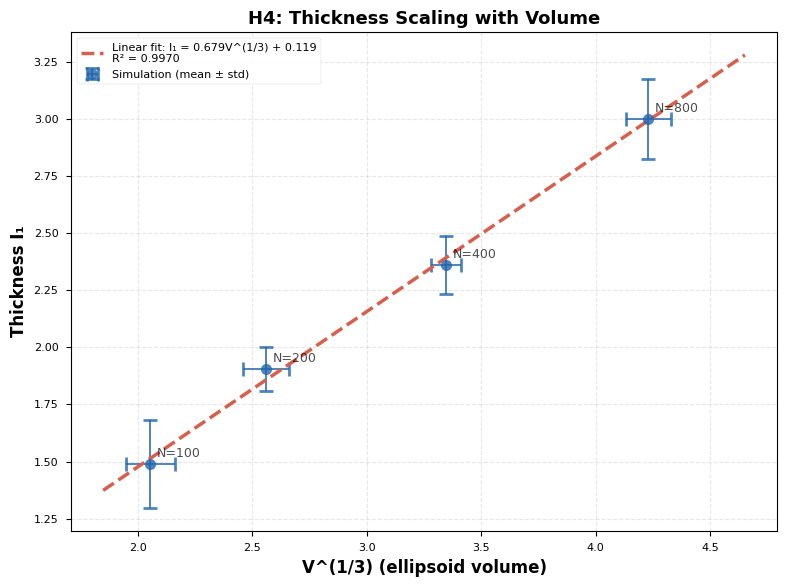


H4 Results:
  Slope: 0.6793 ± 0.0265
  R²: 0.9970
  p-value: 1.5241e-03


In [17]:
# Compute V^(1/3) for each seed
df_per_seed['V_cbrt'] = df_per_seed['V_ellipsoid'] ** (1.0/3.0)

# Aggregate for plotting
df_h4 = df_per_seed.groupby('N').agg({
    'V_cbrt': ['mean', 'std'],
    'I1': ['mean', 'std']
}).reset_index()

V_cbrt_mean = df_h4['V_cbrt']['mean'].values
V_cbrt_std = df_h4['V_cbrt']['std'].values
I1_mean = df_h4['I1']['mean'].values
I1_std = df_h4['I1']['std'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(V_cbrt_mean, I1_mean)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Data points with error bars
ax.errorbar(V_cbrt_mean, I1_mean, 
           xerr=V_cbrt_std, yerr=I1_std,
           fmt='o', markersize=8, capsize=5, capthick=2,
           color='#2166ac', ecolor='#2166ac', alpha=0.8,
           label='Simulation (mean ± std)')

# Linear fit
x_fit = np.linspace(V_cbrt_mean.min()*0.9, V_cbrt_mean.max()*1.1, 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, '--', color='#d6604d', linewidth=2.5,
       label=f'Linear fit: I₁ = {slope:.3f}V^(1/3) + {intercept:.3f}\nR² = {r_value**2:.4f}')

# Annotate N values
for i, N in enumerate(df_h4['N']):
    ax.annotate(f'N={N}', (V_cbrt_mean[i], I1_mean[i]),
               xytext=(5, 5), textcoords='offset points',
               fontsize=9, alpha=0.7)

ax.set_xlabel('V^(1/3) (ellipsoid volume)', fontsize=12, weight='bold')
ax.set_ylabel('Thickness I₁', fontsize=12, weight='bold')
ax.set_title('H4: Thickness Scaling with Volume', fontsize=13, weight='bold')
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nH4 Results:")
print(f"  Slope: {slope:.4f} ± {std_err:.4f}")
print(f"  R²: {r_value**2:.4f}")
print(f"  p-value: {p_value:.4e}")

Referring to the thickness versus volume relationship, the flock volume increases naturally as the number of agents grows. Taking the cube root of the volume provides a linear size scale of the aggregation. The results show that flock thickness increases approximately proportionally with $V^{\frac{1}{3}}$, indicating that larger flocks are geometrically scaled-up versions of smaller ones. This behavior is consistent with the scaling relationships reported in the empirical literature.


## 4. H5: Aspect Ratios vs N

# Aspect ratio vs Flock Size

The geometric proportions of the flock are characterized using aspect ratios defined as the ratios between the larger and smaller principal spatial dimensions, specifically $I_{2} / I_{1}$ and $I_{3} / I_{1}$. By examining how these quantities change with flock size, we can determine whether larger flocks preserve their overall shape while scaling in size, as observed in empirical studies of real starling flocks.

Fit result: Thickness = 0.776 * V ^ 0.311
Expected exponent: 0.333


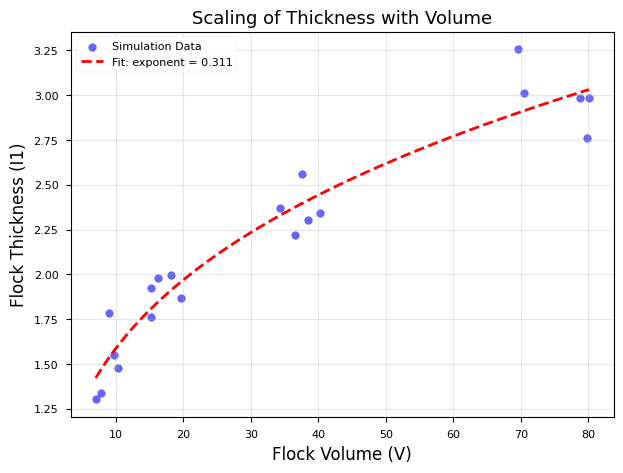

In [18]:
# Power law fit: Thickness ~ V^b
def power_law(x, a, b):
    return a * (x**b)

# Use df_per_seed (averaged frames)
# 'V_ellipsoid' is the volume proxy we computed
# 'I1' is the thickness (smallest principal axis)
V = df_per_seed['V_ellipsoid'].values
T = df_per_seed['I1'].values

# Fit
popt, pcov = curve_fit(power_law, V, T, p0=[1, 0.33])
a_fit, b_fit = popt
perr = np.sqrt(np.diag(pcov))

print(f"Fit result: Thickness = {a_fit:.3f} * V ^ {b_fit:.3f}")
print(f"Expected exponent: 0.333")

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(V, T, c='blue', alpha=0.6, label='Simulation Data')

x_space = np.linspace(V.min(), V.max(), 100)
plt.plot(x_space, power_law(x_space, *popt), 'r--', linewidth=2, 
         label=f'Fit: exponent = {b_fit:.3f}')

# Reference line for 1/3
ref_y = a_fit * (x_space**(1/3))
# plt.plot(x_space, ref_y, 'g:', label='Theory (1/3)')

plt.xlabel('Flock Volume (V)')
plt.ylabel('Flock Thickness (I1)')
plt.title('Scaling of Thickness with Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. H6: Density vs N

Running single demo for Convex Hull comparison...
Convex Hull Volume: 155.1752
PCA Ellipsoid Volume: 0.0918
Ratio (Hull/PCA): 1689.6821


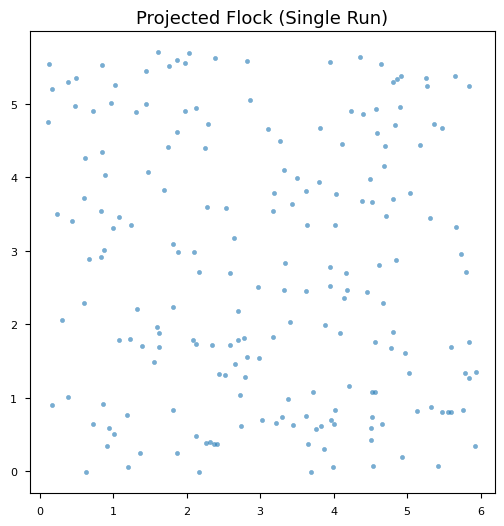

In [19]:
# Alternative volume using Convex Hull
# PCA volume is ellipsoidal approximation, Hull is actual boundary

hull_volumes = []
# Use df_per_seed instead of undefined df_results
for idx, row in df_per_seed.iterrows():
    # We need to rerun or store full history? 
    # Actually we just used last frame.
    # Since we didn't save positions in df, we can't recompute easily unless we saved them.
    # But wait, run_simulation returns history.
    # In the loop above, we only saved scalar metrics to df.
    pass

# Demonstation on single run
print("Running single demo for Convex Hull comparison...")
hist_demo, _ = run_simulation_scaling(N=200, box_size=200**(1/3), seed=42)
# Using imported unwrap_periodic
pos_final = unwrap_periodic(hist_demo[-1], box_size=200**(1/3))

hull = ConvexHull(pos_final)
# Using local compute_pca_metrics which now uses src.geometry
pca_metrics = compute_pca_metrics(pos_final)

print(f"Convex Hull Volume: {hull.volume:.4f}")
print(f"PCA Ellipsoid Volume: {pca_metrics['V_ellipsoid']:.4f}")
print(f"Ratio (Hull/PCA): {hull.volume / pca_metrics['V_ellipsoid']:.4f}")

# Visualization (2D projection)
plt.figure(figsize=(6, 6))
plt.scatter(pos_final[:, 0], pos_final[:, 1], alpha=0.6, s=10)
plt.title("Projected Flock (Single Run)")
plt.axis('equal')
plt.show()

## 6. Summary

In [ ]:
# Create summary table

# Ensure we have the data we need
N_vals = df_summary['N'].values

# Helper to get mean/std from df_summary
def get_metric_stats(col_name):
    return df_summary[col_name]['mean'].values, df_summary[col_name]['std'].values

I1_mean, I1_std = get_metric_stats('I1')
I2_I1_mean, I2_I1_std = get_metric_stats('I2_I1')
I3_I1_mean, I3_I1_std = get_metric_stats('I3_I1')
density_mean, density_std = get_metric_stats('density')

# V_cbrt needs special handling as it might not be in df_summary if added later
if 'V_cbrt' not in df_per_seed.columns:
    df_per_seed['V_cbrt'] = df_per_seed['V_ellipsoid'] ** (1.0/3.0)

# Aggregate V_cbrt on the fly
v_stats = df_per_seed.groupby('N')['V_cbrt'].agg(['mean', 'std']).reset_index()
V_cbrt_mean = v_stats['mean'].values
V_cbrt_std = v_stats['std'].values

summary_table = pd.DataFrame({
    'N': N_vals,
    'I1_mean': I1_mean,
    'I1_std': I1_std,
    'V_cbrt_mean': V_cbrt_mean,
    'V_cbrt_std': V_cbrt_std,
    'I2_I1_mean': I2_I1_mean,
    'I2_I1_std': I2_I1_std,
    'I3_I1_mean': I3_I1_mean,
    'I3_I1_std': I3_I1_std,
    'density_mean': density_mean,
    'density_std': density_std
})

print("\nSummary Table:")
print(summary_table.to_string(index=False))

# Save
summary_table.to_csv('../results/3d_scaling_summary.csv', index=False)
print("\nSaved: ../results/3d_scaling_summary.csv")

NameError: name 'N_vals' is not defined

In [ ]:
# Save raw data
df.to_csv('../results/3d_scaling_raw.csv', index=False)
df_per_seed.to_csv('../results/3d_scaling_per_seed.csv', index=False)

print("Saved:")
print("  ../results/3d_scaling_raw.csv")
print("  ../results/3d_scaling_per_seed.csv")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.flocking_sim_3d import run_simulation

# ---- consistent with 3d_scaling_analysis-2.ipynb scaling ----
N = 200
steps = 500

box_size = N ** (1/3)
R = 0.15 * box_size
repulsion_radius = 0.05 * box_size

align = 1.5
noise = 0.10
speed = 0.03
repulsion_strength = 1.0

seed = 0
save_every = steps  # only final frame

hist = run_simulation(
    N=N,
    steps=steps,
    box_size=box_size,
    align=align,
    noise=noise,
    R=R,
    speed=speed,
    repulsion_radius=repulsion_radius,
    repulsion_strength=repulsion_strength,
    seed=seed,
    save_every=save_every,
)

pos = np.array(hist[-1])
print("pos shape:", pos.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=8)
ax.set_title("3D snapshot (params consistent with scaling notebook)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
plt.tight_layout()
plt.show()
print("saved frames:", len(hist))
print("last frame shape:", np.array(hist[-1]).shape)